In [2]:
from nilearn import plotting, image
import nibabel as nib
import os
import numpy as np
from pathlib import Path
import tarfile
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sub_list = os.listdir("HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2")
make_path = lambda x: "HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2" + "/" + x

In [5]:
def data_uploader(file_path):
    with open(file_path, "r") as f:
        data = []
        for line in f.readlines():
            line = line.strip().split(" ")
            data.append(line)
    X = np.array(data).astype(float)
    return X

In [6]:
paths_100 = [make_path(i) for i in sub_list]
sub_data = [data_uploader(path) for path in paths_100]

### One Subject

In [7]:
path = make_path(sub_list[0])
data = data_uploader(path)
X = np.array(data).astype(float)
X.shape #timepoints, brain regions

(4800, 100)

In [8]:
corr1 = np.corrcoef(X.T)
corr1.shape

(100, 100)

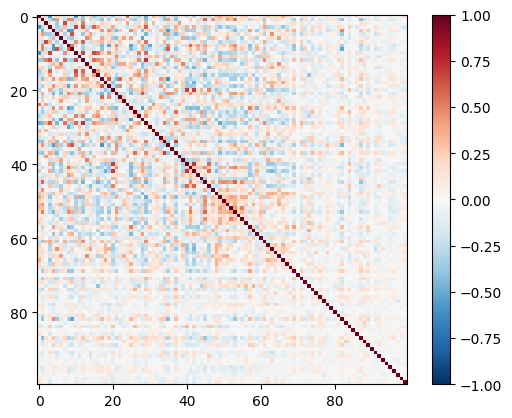

In [10]:
plt.imshow(corr1, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

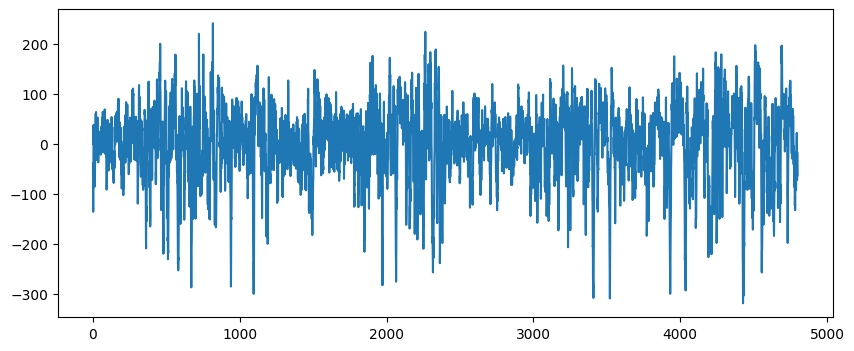

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(X.T[0])

In [12]:
np.std(X.T[0])

np.float64(74.47529661688012)

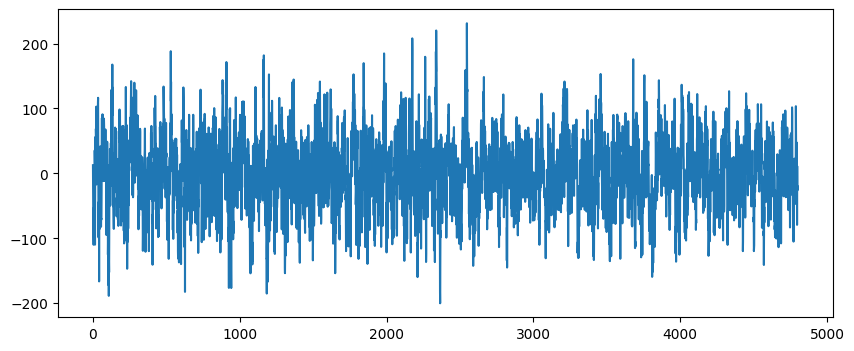

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(X.T[50])

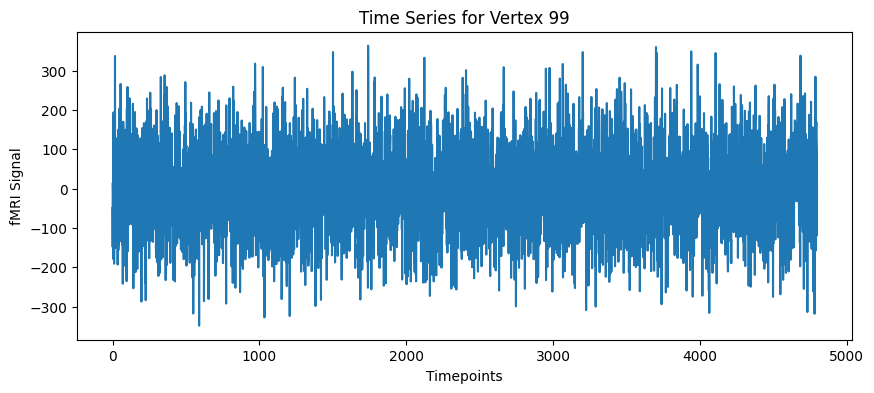

In [14]:
vertex_idx = 99
plt.figure(figsize=(10, 4))
plt.plot(X[0:, vertex_idx])
plt.title(f'Time Series for Vertex {vertex_idx}')
plt.xlabel('Timepoints')
plt.ylabel('fMRI Signal')
plt.show()

### Part 1: Try to average over multiple subjects

In [15]:
import nilearn.connectome as nc

In [16]:
sum(sub_data[1][:, 0])

np.float64(6.378021999998552)

In [17]:
sub_data[1].sum(axis=0)

array([ 6.378022  ,  0.48842   , -0.0140024 ,  1.903131  ,  0.798806  ,
        0.566513  ,  0.825554  ,  1.472018  , -5.518307  ,  0.5224174 ,
       -1.8758441 ,  1.3376301 , -0.466095  , -0.98502   , -4.282556  ,
       -1.886299  , -0.588089  ,  4.5858235 ,  1.34594208, -0.8541046 ,
        0.845162  , -1.00281   ,  0.1153546 , -1.0190523 ,  4.235223  ,
       10.9612159 , -0.6192982 ,  6.6068286 , -4.059312  , -0.406314  ,
        2.5386725 ,  1.43454   ,  3.13452   , -0.187211  , -1.092368  ,
       -1.228717  , -1.17849944, -3.284346  ,  2.517338  , -3.5654151 ,
        1.848404  , -2.624229  ,  1.516147  ,  0.765422  , -0.7892451 ,
        0.4831056 , -1.7621382 , -0.5358952 ,  0.530287  , -2.2177345 ,
       -3.873306  , -0.9315452 , -9.5900596 ,  0.249677  ,  1.12742   ,
       -0.9691555 , -0.2981493 ,  0.0155497 ,  1.0094118 ,  3.283138  ,
       -7.184701  ,  5.59637102,  3.562725  ,  1.4020335 ,  1.091671  ,
       -0.203821  , -2.6281391 , -1.356448  , -2.123287  ,  0.69

In [ ]:
sub_data_var1 = np.array([sub/ sub.std(axis=0) for sub in sub_data]) #sub_data[1] / sub_data[1].std(axis=0)

In [ ]:
cm = nc.GroupSparseCovariance()
cov_matrix = cm.fit(sub_data_var1)

In [ ]:
#computes all covariances at once? Not sure how to combine these still
cm.covariances_

In [114]:
#average each region signal across all subjects
X = sub_data_var1.mean(axis=0)
corr = np.corrcoef(X.T)

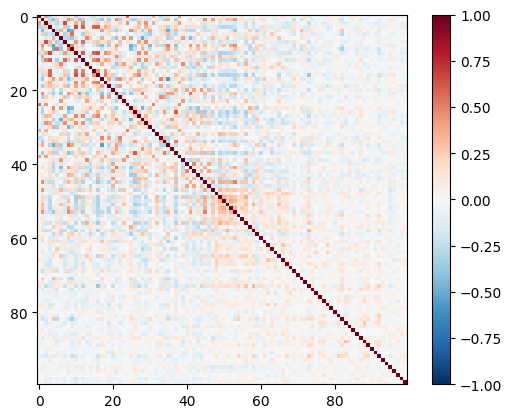

In [115]:
plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

In [110]:
#same thing d=but data variance is not equal to 1
X = np.array(sub_data).mean(axis=0)
corr = np.corrcoef(X.T)

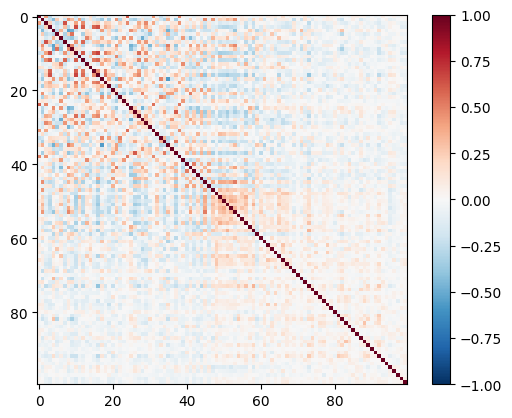

In [111]:
plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

In [120]:
#averaging covariance matrices
combined_covariance = np.mean(cm.covariances_, axis=0)

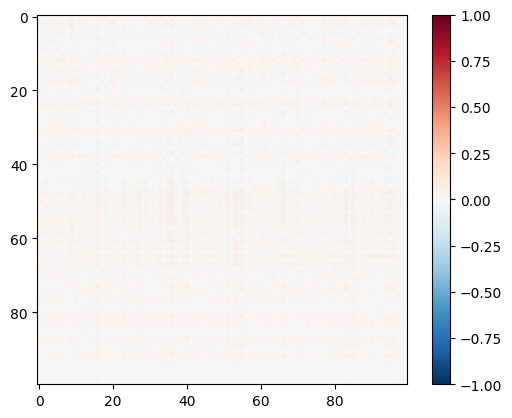

In [121]:
plt.imshow(combined_covariance, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

In [94]:
#Hierarchial Bayesian Model???

### Part 2: Try to map brain connectivity

atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


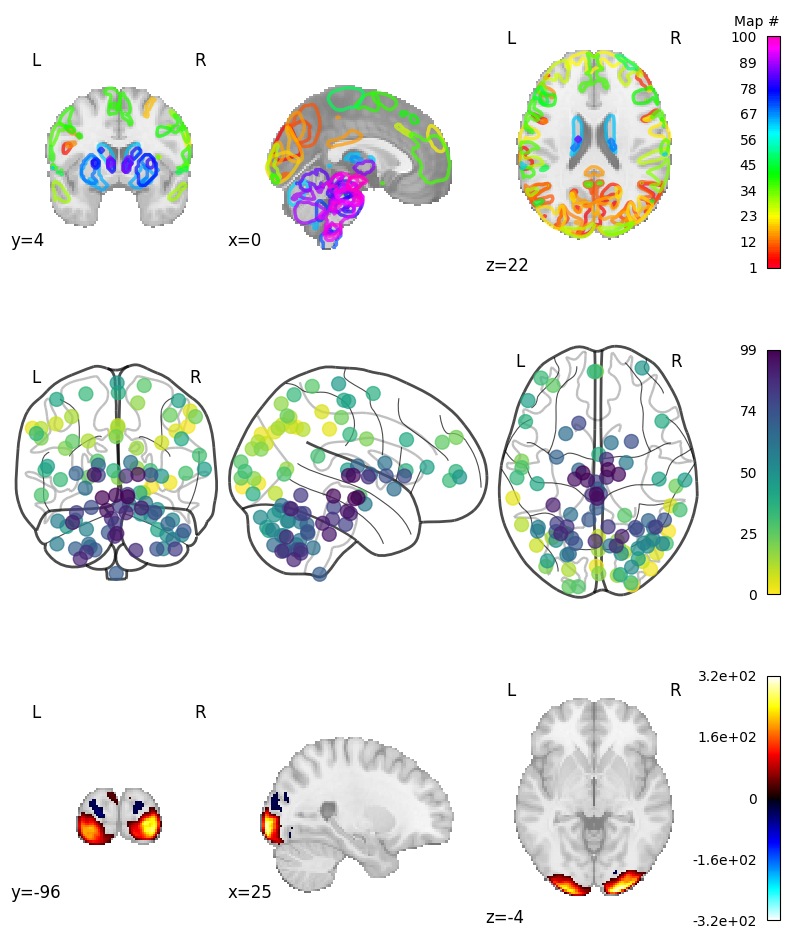

In [63]:
atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 
print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

fig, axs = plt.subplots(nrows=3, figsize=(10, 12))

# plot atlas, all regions
plotting.plot_prob_atlas(atlas, colorbar=True, draw_cross=False, axes=axs[0])

# plot atlas, center coordinates
# get the x,y,z coordinates for each of the regions
atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)
plotting.plot_markers(node_values=np.arange(100), node_coords=atlas_coords, axes=axs[1])

# plot atlas, one region
idx = 0 # first region
atlas_region = image.index_img(atlas, idx)
plotting.plot_stat_map(
    atlas_region, draw_cross=False, axes=axs[2]
)

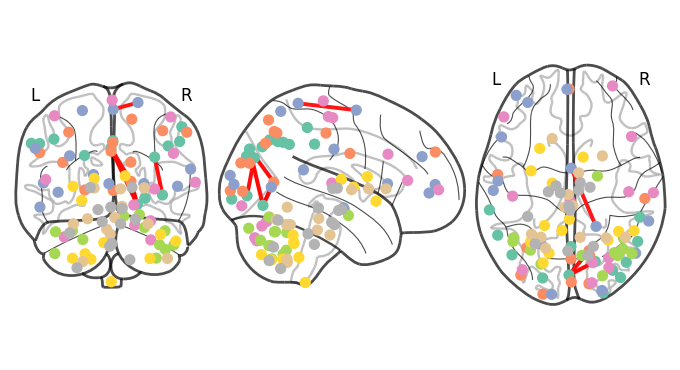

In [65]:
# plot it on the brain (averaging over all subjects)
plotting.plot_connectome(corr, atlas_coords, edge_threshold="99.9%")

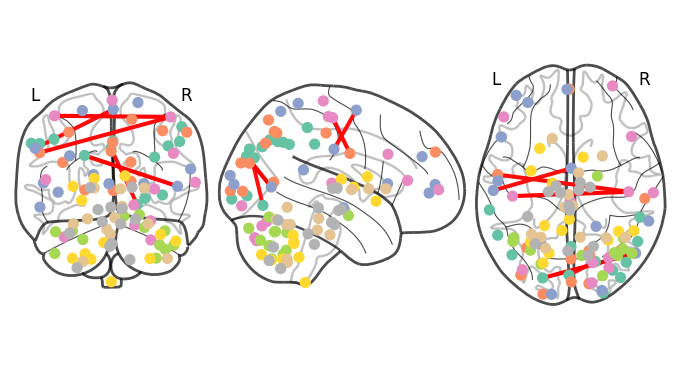

In [72]:
# plot it on the brain on one subject!!!
plotting.plot_connectome(corr1, atlas_coords, edge_threshold="99.9%")

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_6000/4178750242.py:1: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(combined_covariance, atlas_coords, edge_threshold="99.9%")


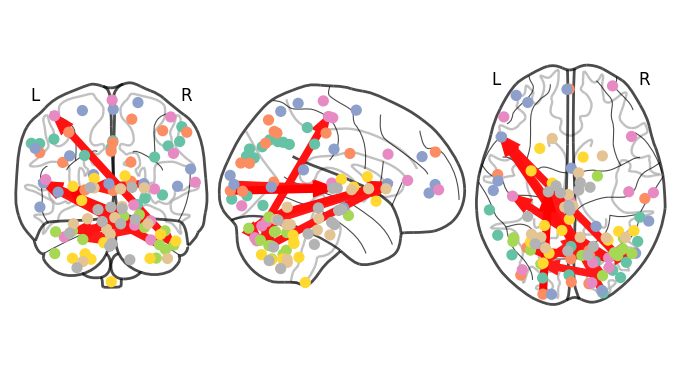

In [92]:
plotting.plot_connectome(combined_covariance, atlas_coords, edge_threshold="99.9%")

### Part 3: Try sliding window averaging covariance matrix